In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import json
from torch.utils.data import Dataset, DataLoader, random_split
import re
from sklearn.utils import shuffle

In [2]:
def get_data(filename):
    
    with open(filename, 'r', encoding='utf-8') as file:
        data = json.load(file)

    df = pd.DataFrame(data)
    return df

data = get_data('output_file copy.json')
# data = get_data('./rnn/only_action_method/output_file copy.json')

data.head()

,content_syntactic_blocstring,action_blocstring,changes_list_content_syntactic_,changes_list_action,src,userId,user_class,tweet_count,change_content_syntactic,change_action,change_change_dynamic_score,highest_change_in_content_syntactic,lowest_change_in_content_syntactic,standard_deviation_of_content_syntactic,highest_change_in_action,lowest_change_in_action,standard_deviation_of_action,diversity_action,diversity_content_syntactic,diversity_change_dynamics_score
0,(mmmmmmmmqt)(mmmmmmmmqt)(mmmmmmmmqt)(mmmmmmmmq...,rprp⚀pr□prrprrrprpprprprprprpprprprp□rprprprrr...,"[0.683772233983162, 0.00647286670992131, 0.801...","{'content_syntactic': [0.683772233983162, 0.00...",astroturf,146048090,bot,274,0.556376,0.297313,1.024345,0.938307,0.006473,0.275047,0.901294,0.054951,0.200933,0.653102,0.652532,0.450906
1,(mmmmmmmqt)(mmmmmmmqt)(mmmmmmmqt)(mmmmmmmqt)(m...,r□pr□rr□rp⚀r⚀TTTTTTT□r⚀p⚀π□p|⚀rr⚀rr⚀rr□r⚀r|⚀p⚀...,"[0.0600874600144512, 0.022936062507937005, 0.0...","{'content_syntactic': [0.0600874600144512, 0.0...",astroturf,797927149856403456,bot,275,0.427565,0.484909,0.711994,1.000000,0.004220,0.356787,0.989180,0.068479,0.291316,0.707387,0.693840,0.151417
2,(mmt)(mmt)(qt)(qt)(qt)(mqt)(qt)(t)(qt)(qt)(Em)...,r□r⚀r⚀rr□rrr□r□r⚀rrr⚀r|⚁rrrrr□rrrrrr□rpprrrp□r...,"[0.4050577935998917, 0.2173762078750736, 0.181...","{'content_syntactic': [0.4050577935998917, 0.2...",astroturf,1046169889138868225,bot,277,0.442671,0.284123,1.405920,1.000000,0.015253,0.265496,0.913974,0.045573,0.204972,0.676182,0.644029,0.297367
3,(mmt)(mmmmmmqt)(mmmmmmmmmqt)(mmt)(mmt)(qt)(mmm...,prrpp□rrrrrrrrrrrrrr□rr□rrr□rrprrrrrrr□prrrrrr...,"[0.6288092648051271, 0.17944110183186945, 1.0,...","{'content_syntactic': [0.6288092648051271, 0.1...",astroturf,1085010463128195073,bot,244,0.368786,0.419595,1.029069,1.000000,0.111362,0.206134,1.000000,0.049906,0.306818,0.698081,0.620676,0.211830
4,(mmmmmmmqt)|(Em)|(t)(mmqt)(mt)(mmt)|(qt)(HUqt)...,p|⚁p|⚀p□p□p□p|⚁rrrrrrrrpr□prrprr□rrrprrprrrprp...,"[1.0, 1.0, 0.7298648986655512, 0.8616571072267...","{'content_syntactic': [1.0, 1.0, 0.72986489866...",astroturf,1613166488,bot,245,0.618332,0.353069,0.605766,1.000000,0.209196,0.253005,0.849471,0.075654,0.199506,0.680286,0.766445,0.627025


In [3]:
import numpy as np

# data = data[~data['src'].isin(['astroturf', 'pronbots-19', 'political-bots-19'])]
# np.unique(data['src'])

In [4]:
print("Original class distribution:")
print(data['user_class'].value_counts())

# Separate data by user_class
bots = data[data['user_class'] == 'bot']
humans = data[data['user_class'] == 'human']

# Select the minimum class size
min_class_size = min(len(bots), len(humans))

# Downsample each class to the minimum class size
bots_balanced = bots.sample(n=min_class_size, random_state=1)
humans_balanced = humans.sample(n=min_class_size, random_state=1)

# Combine the balanced classes
balanced_data = pd.concat([bots_balanced, humans_balanced])

# Shuffle the data
balanced_data = shuffle(balanced_data, random_state=1).reset_index(drop=True)

print("Balanced class distribution:")
print(balanced_data['user_class'].value_counts())

data = balanced_data

Original class distribution:
user_class
bot      32041
human    27704
Name: count, dtype: int64
Balanced class distribution:
user_class
human    27704
bot      27704
Name: count, dtype: int64


In [5]:
class UserDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data.loc[idx, 'action_blocstring']
        label = 1 if self.data.loc[idx, 'user_class'] == 'bot' else 0
        return {
            'text': text, 
            'label': label 
        }

dataset = UserDataset(data)

train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Example usage: Iterate through the test loader
# for batch in val_loader:
#     print(batch['text'], batch['label'])


In [6]:
# Counter: subclass of Python's dictionary used for counting hashable objects, in this case, tokens (words).
# OrderedDict: subclass of Python's dictionary that remembers the insertion order of keys. It is used to store tokens in a specific order based on frequency.
from collections import Counter, OrderedDict
# re: A module for working with regular expressions, used to manipulate and clean text.
import re

# Token counts and vocab creation
# Initializes an empty Counter object to hold the frequency of each token in the dataset.
token_counts = Counter()

# Define tokenizer
def tokenizer(text):

    #  replace | with " "
    # text = text.replace("|", " ")

    return list(text)

# Tokenize the training data and populate token_counts
for entry in train_dataset:  # Assuming train_dataset is a dataset with 'text'
    line = entry['text']
    tokens = tokenizer(line)
    token_counts.update(tokens)

# Sort tokens by frequency
# token_counts.items() returns the tokens and their respective counts as a list of tuples (e.g., [(token1, count1), (token2, count2), ...])
# key=lambda x: x[1] means that the sorting is based on the count (x[1]), which is the second element of each tuple
# reverse=True means that the most frequent tokens appear first in the sorted list.
sorted_by_freq_tuples = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)

# Create an ordered dictionary for the vocab
ordered_dict = OrderedDict(sorted_by_freq_tuples)

# The padding token (pad) is used to ensure that all sequences in a batch have the same length.
# The unknown token (unk) is used to represent words that are not found in the model's vocabulary (the top 69021 words in your case).
# Any word that doesn't appear in the vocabulary is replaced by the unk token during tokenization.
# This is critical for handling unseen words during inference, where the model encounters words that were not present in the training data.
# Create vocab dictionary with special tokens
# Initializes the vocab dictionary with two special tokens
vocab = {"<pad>": 0, "<unk>": 1}

for idx, (token, count) in enumerate(ordered_dict.items(), start=2):  # Start from 2 to skip the special tokens
    vocab[token] = idx


# Print the vocabulary size (should be 69023)
print('Vocab-size:', len(vocab))
print('vocab', vocab)
# --- Rationale:
#
# By assigning frequent words lower indices, we can optimize memory and computational efficiency.
# Words that appear infrequently can either be assigned higher indices (in case we want to keep them) or omitted from the vocabulary entirely.

Vocab-size: 15
vocab {'<pad>': 0, '<unk>': 1, '|': 2, 'r': 3, 'T': 4, '⚁': 5, '⚀': 6, 'p': 7, '□': 8, '⚂': 9, '⚃': 10, 'π': 11, '⚄': 12, 'ρ': 13, '⚅': 14}


In [7]:
# action T|⚂T|⚅T□TT□r⚀r⚀r|⚀r|⚀r□r⚀r|⚂rTT□r□r⚀r□r|⚀r⚀r⚀r

# content (t)|(t)|(Et)(E)(Et)(qt)(Et)(EHUt)|(Et)|(mUt)(HHHHHHt)(qt)|(qt)(E)(Et)(mmmqt)(Et)(HUt)(Ut)|(qt)(mqt)(EHUt)

# text (T -> t)|(⚂)(T -> t)|(⚅)(T -> Et)(□)(T -> E)(T -> Et)(□)(r -> qt)(⚀)(r -> Et)(⚀)(r -> EHUt)|(⚀)(r -> Et)|(⚀)(r -> mUt)(□)

def encode(tokens):
    #If the token does not exist in the vocab, the function returns the index of the <unk>
    return [vocab.get(token, vocab["<unk>"]) for token in tokens]
# Example usage
print(encode(tokenizer('(T -> t)|(⚂)(T -> t)|(⚅)(T -> Et)(□)(T -> E)(T -> Et)(□)(r -> qt)(⚀)(r -> Et)(⚀)(r -> EHUt)|(⚀)(r -> Et)|(⚀)(r -> mUt)(□)')))  # Should output something like [11, 7, 35, 457]

[1, 4, 1, 1, 1, 1, 1, 1, 2, 1, 9, 1, 1, 4, 1, 1, 1, 1, 1, 1, 2, 1, 14, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 6, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 6, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1]


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use the manual vocab creation process from earlier
# Assuming `vocab` and `tokenizer` are already defined

#text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]
# Updated text pipeline
text_pipeline = lambda x: [vocab.get(token, vocab["<unk>"]) for token in tokenizer(x)]

label_pipeline = lambda x: float(x)  # Convert to float to match the output

# Batch collation function
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for entry in batch:  # Each 'entry' is a dictionary with 'text' and 'label'
        _label = entry['label']
        _text = entry['text']

        # Process labels and text
        label_list.append(label_pipeline(_label))  # Convert labels using label_pipeline
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)  # Convert text to indices

        # Store processed text and its length
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))

    # Convert lists to tensors and pad sequences
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    padded_text_list = nn.utils.rnn.pad_sequence(text_list, batch_first=True)

    return padded_text_list.to(device), label_list.to(device), lengths.to(device)

In [9]:
#-----  Example usage with DataLoader -----#
## Take a small batch

dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn=collate_batch)
text_batch, label_batch, length_batch = next(iter(dataloader))

# Print the output batch
print("Text batch:", text_batch)
print("Label batch:", label_batch)
print("Length batch:", length_batch)
print("Text batch shape:", text_batch.shape)

Text batch: tensor([[ 3,  2,  9,  ...,  2, 10,  4],
        [ 4,  6,  4,  ...,  0,  0,  0],
        [ 7,  2,  5,  ...,  0,  0,  0],
        [ 4,  8,  4,  ...,  0,  0,  0]], device='cuda:0')
Label batch: tensor([0., 0., 0., 1.], device='cuda:0')
Length batch: tensor([549, 534, 509, 454], device='cuda:0')
Text batch shape: torch.Size([4, 549])


In [10]:
## Batching the datasets
batch_size = 32
vocab_size = len(vocab)

train_dl = DataLoader(train_dataset, batch_size=batch_size,
                      shuffle=True, collate_fn=collate_batch)
val_dl = DataLoader(val_dataset, batch_size=batch_size,
                      shuffle=False, collate_fn=collate_batch)
test_dl = DataLoader(test_dataset, batch_size=batch_size,
                     shuffle=False, collate_fn=collate_batch)

class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size, num_layers=2, dropout_rate=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, num_layers=num_layers, 
                           batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        self.embedded_text = out.clone().detach().requires_grad_(True)  # Track embeddings for saliency
        out = nn.utils.rnn.pack_padded_sequence(self.embedded_text, lengths.cpu().numpy(), 
                                                enforce_sorted=False, batch_first=True)
        out, (hidden, cell) = self.rnn(out)
        out = hidden[-1, :, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out


def train_epoch(dataloader, model, optimizer, loss_fn):
    model.train()
    total_acc, total_loss = 0, 0
    for text_batch, label_batch, lengths in dataloader:  # Loop through batches in dataloader
        optimizer.zero_grad()
        pred = model(text_batch, lengths)[:, 0]
        loss = loss_fn(pred, label_batch)
        loss.backward()
        optimizer.step()
        total_acc += ((pred >= 0.5).float() == label_batch).float().sum().item()
        total_loss += loss.item() * label_batch.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

def evaluate_epoch(dataloader, model, loss_fn):
    model.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:  # Loop through batches in dataloader
            pred = model(text_batch, lengths)[:, 0]
            loss = loss_fn(pred, label_batch)
            total_acc += ((pred >= 0.5).float() == label_batch).float().sum().item()
            total_loss += loss.item() * label_batch.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

Epoch 1 - train_accuracy: 0.7961, val_accuracy: 0.8812, train_loss: 0.4641, val_loss: 0.3182


Epoch 2 - train_accuracy: 0.8808, val_accuracy: 0.6730, train_loss: 0.3172, val_loss: 0.6579


Epoch 3 - train_accuracy: 0.8952, val_accuracy: 0.8881, train_loss: 0.2890, val_loss: 0.2768


Epoch 4 - train_accuracy: 0.9021, val_accuracy: 0.9019, train_loss: 0.2608, val_loss: 0.2466


Epoch 5 - train_accuracy: 0.9039, val_accuracy: 0.9066, train_loss: 0.2520, val_loss: 0.2367


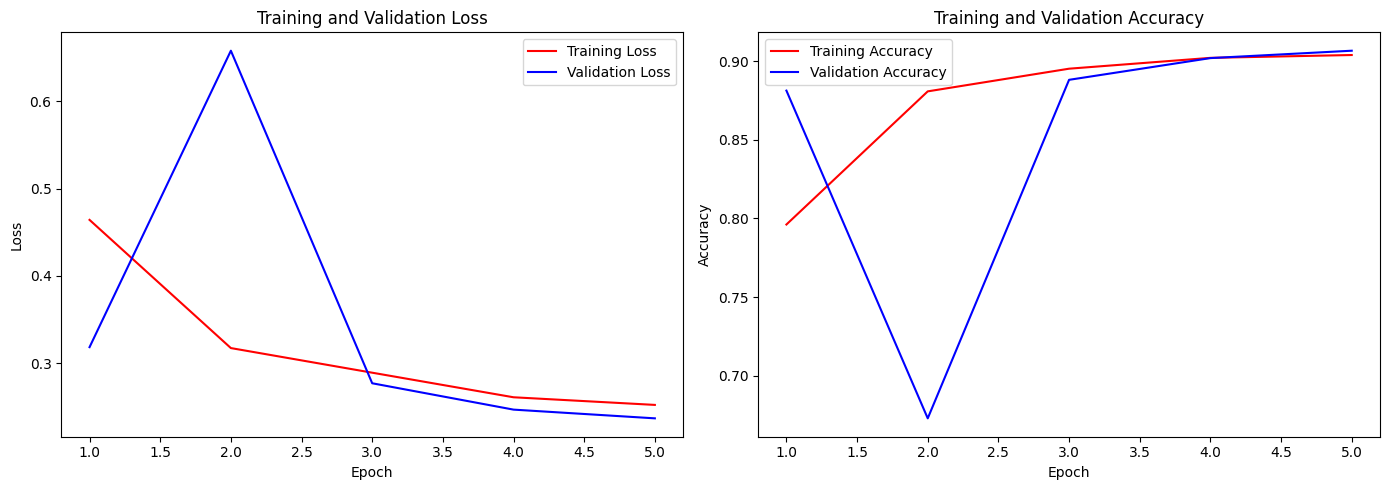

In [11]:
# Train with the best hyperparameters
lr                   = 0.001
embed_dim            = 64
rnn_hidden_size      = 128
fc_hidden_size       = 64
num_layers           = 2
dropout_rate         = 0

model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

# Initialize lists to store training and validation metrics for each epoch
train_accuracies = []
train_losses = []
valid_accuracies = []
valid_losses = []

num_epochs = 5 #40
early_stop_patience = 10  # Stop training if no improvement after this many epochs

best_val_loss = 10

# Training loop with early stopping
for epoch in range(num_epochs):

    acc_train, loss_train = train_epoch(train_dl, model, optimizer, loss_fn)
    acc_valid, loss_valid = evaluate_epoch(val_dl, model, loss_fn)

    # Store metrics
    train_accuracies.append(acc_train)
    train_losses.append(loss_train)
    valid_accuracies.append(acc_valid)
    valid_losses.append(loss_valid)

    print(f'Epoch {epoch + 1} - train_accuracy: {acc_train:.4f}, val_accuracy: {acc_valid:.4f}, train_loss: {loss_train:.4f}, val_loss: {loss_valid:.4f}')

    # Early stopping check
    if loss_valid < best_val_loss:
        best_val_loss = loss_valid
        best_epoch = epoch
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch + 1}. Best validation loss was {best_val_loss:.4f} at epoch {best_epoch + 1}.")
        break

# Adjust x-values to match the actual number of epochs completed
epochs_completed = len(train_losses)  # Get the actual number of epochs completed

plt.figure(figsize=(14, 5))

# Plot Training and Validation Losses
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_completed + 1), train_losses, label='Training Loss', color='red')
plt.plot(range(1, epochs_completed + 1), valid_losses, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Training and Validation Accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_completed + 1), train_accuracies, label='Training Accuracy', color='red')
plt.plot(range(1, epochs_completed + 1), valid_accuracies, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
evaluate_epoch(test_dl, model, loss_fn)

(0.9062528196336732, 0.242804526212488)

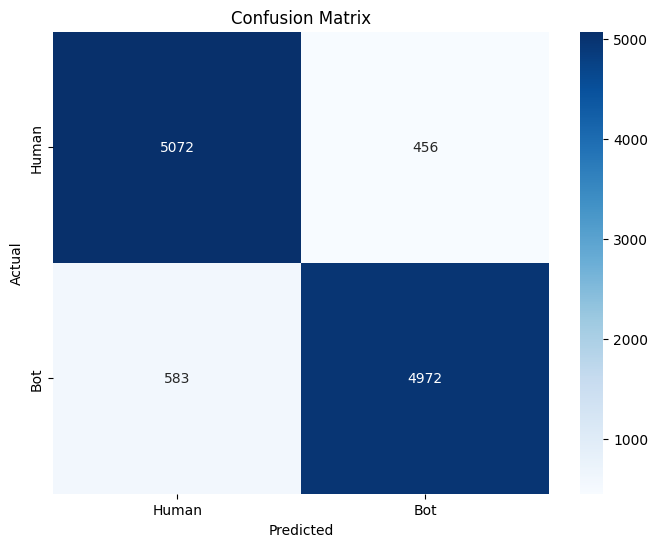

In [13]:
# Generate confusion matrix
def generate_confusion_matrix(dataloader, model):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:
            preds = model(text_batch, lengths)[:, 0]
            all_preds.extend((preds >= 0.5).cpu().numpy())
            all_labels.extend(label_batch.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Bot'], yticklabels=['Human', 'Bot'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Generate confusion matrix on the test dataset
generate_confusion_matrix(test_dl, model)

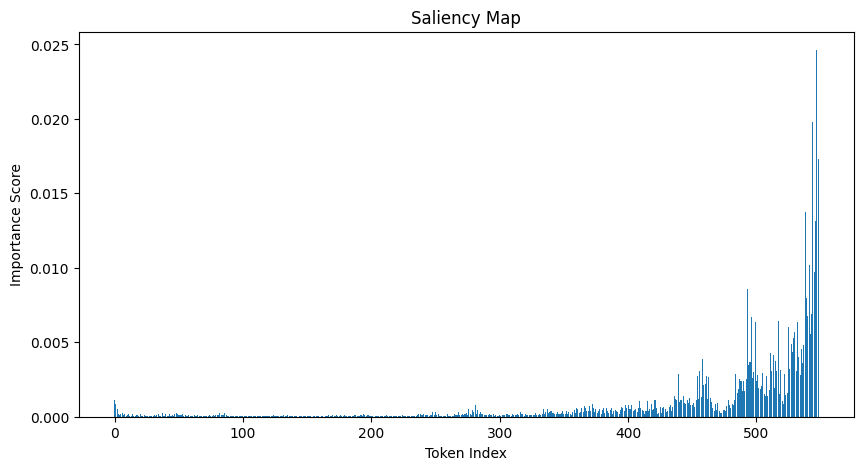

In [14]:
def get_saliency_map(model, text_batch, lengths, target_index=0):
    model.eval()

    # Temporarily enable training mode for the RNN to allow gradients
    model.rnn.train()  # Re-enable RNN gradient tracking
    
    # Ensure gradients are enabled for embedded text
    model.embedded_text.requires_grad = True

    # Forward pass
    pred = model(text_batch, lengths)[:, 0]

    # Select the prediction index to analyze
    pred[target_index].backward()  # Backpropagate from the chosen prediction

    # Obtain the gradient of the embeddings
    saliency = model.embedded_text.grad.abs().sum(dim=2).squeeze(0)
    
    # Return the RNN back to evaluation mode to ensure correct behavior
    model.rnn.eval()

    return saliency

# Example usage
text_sample = text_batch[0].unsqueeze(0)  # Pick one sample
length_sample = torch.tensor([length_batch[0].item()])  # Corresponding length
saliency_map = get_saliency_map(model, text_sample, length_sample)

# Visualizing
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(range(len(saliency_map)), saliency_map.cpu().detach().numpy())
plt.title("Saliency Map")
plt.xlabel("Token Index")
plt.ylabel("Importance Score")
plt.show()


In [15]:
from IPython.display import display, HTML
import numpy as np

def highlight_text(input_text, saliency_map, tokenizer=None):
    # Normalize saliency values to range [0, 1]
    saliency_norm = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
    
    # Generate HTML with highlighted tokens
    highlighted_text = ""
    for idx, token in enumerate(input_text):
        intensity = saliency_norm[idx].item()
        color = f'rgba(255, 0, 0, {intensity})'  # Red intensity based on saliency
        highlighted_text += f'<span style="background-color: {color}; padding: 2px 4px; border-radius: 4px;">{token}</span> '

    display(HTML(f"<div style='font-family: monospace; line-height: 1.6;'>{highlighted_text}</div>"))

# Example usage
text_sample = text_batch[0].unsqueeze(0)
length_sample = torch.tensor([length_batch[0].item()])
saliency_map = get_saliency_map(model, text_sample, length_sample)

# Convert tensor indices to words (assuming a tokenizer is available)
tokenizer = lambda x: [str(word.item()) for word in x]  # Simple tokenizer example
highlight_text(tokenizer(text_sample[0]), saliency_map)

In [16]:
from IPython.display import display, HTML
import numpy as np

# Vocabulary mapping
vocab = {'<pad>': 0, '<unk>': 1, '|': 2, 'r': 3, 'T': 4, '⚁': 5, '⚀': 6, 
         'p': 7, '□': 8, '⚂': 9, '⚃': 10, 'π': 11, '⚄': 12, 'ρ': 13, '⚅': 14}
index_to_token = {v: k for k, v in vocab.items()}  # Reverse mapping

def highlight_text(input_indices, saliency_map):
    # Convert indices to tokens
    input_tokens = [index_to_token[idx.item()] for idx in input_indices]

    # Normalize saliency values to range [0, 1]
    saliency_norm = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

    # Generate HTML with highlighted tokens
    highlighted_text = ""
    for idx, token in enumerate(input_tokens):
        intensity = saliency_norm[idx].item()
        color = f'rgba(255, 0, 0, {intensity})'  # Red intensity based on saliency
        highlighted_text += f'<span style="background-color: {color}; padding: 2px 4px; border-radius: 4px;">{token}</span> '

    display(HTML(f"<div style='font-family: monospace; line-height: 1.6;'>{highlighted_text}</div>"))

# Example usage
text_sample = text_batch[0].unsqueeze(0)  # Sample data
length_sample = torch.tensor([length_batch[0].item()])  # Corresponding length
saliency_map = get_saliency_map(model, text_sample, length_sample)

# Highlight mapped tokens
highlight_text(text_sample[0], saliency_map)